<a href="https://colab.research.google.com/github/thomas3913/Master_project/blob/main/my_notebook_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Master Project

In [7]:
!git clone https://github.com/thomas3913/Master_project.git
import os
os.chdir("Master_project")
!pip install madmom
!pip install partitura

Cloning into 'Master_project'...
remote: Enumerating objects: 5522, done.
remote: Counting objects: 100% (1362/1362), done.
remote: Compressing objects: 100% (1284/1284), done.
remote: Total 5522 (delta 86), reused 1345 (delta 72), pack-reused 4160
Receiving objects: 100% (5522/5522), 61.03 MiB | 19.97 MiB/s, done.
Resolving deltas: 100% (378/378), done.
Checking out files: 100% (5182/5182), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import pandas as pd
from pathlib import Path
import json
BASE_PATH= "."
import madmom
import librosa
import librosa.display
import csv
#import speech_recognition as sr
import IPython.display as ipd
import partitura as pt
import sys
sys.path.insert(0,'/content/partitura_tutorial/content')
import mir_eval_beat
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import datetime
import math
import seaborn
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

np.set_printoptions(threshold=sys.maxsize)

In [9]:
#get a list of performances such as there are not 2 performances of the same piece
df = pd.read_csv(Path(BASE_PATH,"metadata.csv"))
unique_df = df.drop_duplicates(subset=["title","composer"])
unique_performance_list = unique_df["midi_performance"].tolist()

#get the downbeat_list of a performance of Bach Fugue_bwv_848
midi_path = df.loc[df.title=="Fugue_bwv_848","midi_performance"].iloc[0]
with open(Path(BASE_PATH,'asap_annotations.json')) as json_file:
    json_data = json.load(json_file)
db_list = json_data[midi_path]["performance_downbeats"]

#same task, but using the TSV file
annotation_path = df.loc[df.title=="Fugue_bwv_848","performance_annotations"].iloc[0]
ann_df = pd.read_csv(Path(BASE_PATH,annotation_path),header=None, names=["time","time2","type"],sep='\t')
db_list = [row["time"] for i,row in ann_df.iterrows() if row["type"].split(",")[0]=="db"]

#get all pieces with time signature changes
tsc_pieces = [p for p in json_data.keys() if len(json_data[p]["perf_time_signatures"])>1 ]

In [10]:
midi_test_path = df.loc[df.title=="Fugue_bwv_846","midi_performance"].iloc[0]
#print(midi_test_path)
#print(list(json_data[midi_test_path]["performance_beats_type"].values()))
df

,composer,title,folder,xml_score,midi_score,midi_performance,performance_annotations,midi_score_annotations,maestro_midi_performance,maestro_audio_performance,start,end,audio_performance
0,Bach,Fugue_bwv_846,Bach/Fugue/bwv_846,Bach/Fugue/bwv_846/xml_score.musicxml,Bach/Fugue/bwv_846/midi_score.mid,Bach/Fugue/bwv_846/Shi05M.mid,Bach/Fugue/bwv_846/Shi05M_annotations.txt,Bach/Fugue/bwv_846/midi_score_annotations.txt,{maestro}/2006/MIDI-Unprocessed_19_R1_2006_01-...,{maestro}/2006/MIDI-Unprocessed_19_R1_2006_01-...,144.567708,NaN,Bach/Fugue/bwv_846/Shi05M.wav
1,Bach,Fugue_bwv_848,Bach/Fugue/bwv_848,Bach/Fugue/bwv_848/xml_score.musicxml,Bach/Fugue/bwv_848/midi_score.mid,Bach/Fugue/bwv_848/Denisova06M.mid,Bach/Fugue/bwv_848/Denisova06M_annotations.txt,Bach/Fugue/bwv_848/midi_score_annotations.txt,{maestro}/2008/MIDI-Unprocessed_02_R1_2008_01-...,{maestro}/2008/MIDI-Unprocessed_02_R1_2008_01-...,69.317708,NaN,Bach/Fugue/bwv_848/Denisova06M.wav
2,Bach,Fugue_bwv_848,Bach/Fugue/bwv_848,Bach/Fugue/bwv_848/xml_score.musicxml,Bach/Fugue/bwv_848/midi_score.mid,Bach/Fugue/bwv_848/Lee01M.mid,Bach/Fugue/bwv_848/Lee01M_annotations.txt,Bach/Fugue/bwv_848/midi_score_annotations.txt,{maestro}/2011/MIDI-Unprocessed_08_R1_2011_MID...,{maestro}/2011/MIDI-Unprocessed_08_R1_2011_MID...,74.795573,NaN,Bach/Fugue/bwv_848/Lee01M.wav
3,Bach,Fugue_bwv_848,Bach/Fugue/bwv_848,Bach/Fugue/bwv_848/xml_score.musicxml,Bach/Fugue/bwv_848/midi_score.mid,Bach/Fugue/bwv_848/LeeSH01M.mid,Bach/Fugue/bwv_848/LeeSH01M_annotations.txt,Bach/Fugue/bwv_848/midi_score_annotations.txt,{maestro}/2017/MIDI-Unprocessed_049_PIANO049_M...,{maestro}/2017/MIDI-Unprocessed_049_PIANO049_M...,83.644792,NaN,Bach/Fugue/bwv_848/LeeSH01M.wav
4,Bach,Fugue_bwv_848,Bach/Fugue/bwv_848,Bach/Fugue/bwv_848/xml_score.musicxml,Bach/Fugue/bwv_848/midi_score.mid,Bach/Fugue/bwv_848/Lin04M.mid,Bach/Fugue/bwv_848/Lin04M_annotations.txt,Bach/Fugue/bwv_848/midi_score_annotations.txt,{maestro}/2008/MIDI-Unprocessed_10_R1_2008_01-...,{maestro}/2008/MIDI-Unprocessed_10_R1_2008_01-...,75.373698,NaN,Bach/Fugue/bwv_848/Lin04M.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,Scriabin,Sonatas_5,Scriabin/Sonatas/5,Scriabin/Sonatas/5/xml_score.musicxml,Scriabin/Sonatas/5/midi_score.mid,Scriabin/Sonatas/5/Na03.mid,Scriabin/Sonatas/5/Na03_annotations.txt,Scriabin/Sonatas/5/midi_score_annotations.txt,NaN,NaN,NaN,NaN,NaN
1063,Scriabin,Sonatas_5,Scriabin/Sonatas/5,Scriabin/Sonatas/5/xml_score.musicxml,Scriabin/Sonatas/5/midi_score.mid,Scriabin/Sonatas/5/Na07M.mid,Scriabin/Sonatas/5/Na07M_annotations.txt,Scriabin/Sonatas/5/midi_score_annotations.txt,{maestro}/2009/MIDI-Unprocessed_09_R1_2009_01-...,{maestro}/2009/MIDI-Unprocessed_09_R1_2009_01-...,NaN,NaN,Scriabin/Sonatas/5/Na07M.wav
1064,Scriabin,Sonatas_5,Scriabin/Sonatas/5,Scriabin/Sonatas/5/xml_score.musicxml,Scriabin/Sonatas/5/midi_score.mid,Scriabin/Sonatas/5/TET02.mid,Scriabin/Sonatas/5/TET02_annotations.txt,Scriabin/Sonatas/5/midi_score_annotations.txt,NaN,NaN,NaN,NaN,NaN
1065,Scriabin,Sonatas_5,Scriabin/Sonatas/5,Scriabin/Sonatas/5/xml_score.musicxml,Scriabin/Sonatas/5/midi_score.mid,Scriabin/Sonatas/5/Yeletskiy02.mid,Scriabin/Sonatas/5/Yeletskiy02_annotations.txt,Scriabin/Sonatas/5/midi_score_annotations.txt,NaN,NaN,NaN,NaN,NaN


#### File playground:

In [11]:
x, sr = librosa.load('Balakirev/Islamey/CHEN10M.wav') 
#ipd.Audio(x, rate=sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


NoBackendError: ignored

In [ ]:
tempo, beat_times = librosa.beat.beat_track(x, sr=sr, start_bpm=60, units='time')
clicks = librosa.clicks(beat_times, sr=sr, length=len(x))
#ipd.Audio(x + clicks, rate=sr)

In [ ]:
#print(beat_times)

In [ ]:
proc = madmom.features.beats.DBNBeatTrackingProcessor(fps=100)
act = madmom.features.beats.RNNBeatProcessor()('Balakirev/Islamey/CHEN10M.wav')
beat_times = proc(act)

In [ ]:
clicks = librosa.clicks(beat_times, sr=sr, length=len(x))
#ipd.Audio(x + clicks, rate=sr)
beat_times

In [ ]:
#proc = madmom.features.downbeats.RNNDownBeatProcessor()
#db = proc('Balakirev/Islamey/CHEN10M.wav')
#print(db[0:100])

### Function - Convert beat list to array

In [12]:
def beat_list_to_array(filename, data_type, beat_type):
    beat_list = []
    with open(filename, newline = '\n') as f:                                                                                          
        lines = csv.reader(f, delimiter='\t')
        for line in lines:
            # include downbeats to beats!
            if data_type == "detections":
                beat_list.append(np.float64(line[0]))
                
            elif data_type == "annotations":
                
                if beat_type == "beats":
                    beat_list.append(np.float64(line[0]))

                elif beat_type == "downbeats":
                    if line[2] == 'db':
                        beat_list.append(np.float64(line[0]))
                else:
                    print("Beat type not specified.")
                    raise TypeError       
            else:
                print("Data type not specified.")
                raise TypeError

    beat_array = np.array(beat_list)
    
    return beat_array

#### Evaluation playground

In [13]:
# Load beat times

output_file = 'Balakirev/Islamey/Na08M_output_b.txt'
output_file_db = 'Balakirev/Islamey/Na08M_output_db.txt'

detections_array = beat_list_to_array(output_file,"detections","beats")
detections_array_db = beat_list_to_array(output_file_db,"detections","downbeats")
print(detections_array.shape,detections_array_db.shape)

(659,) (159,)


In [14]:
#detections = beat_times

annotations = 'Balakirev/Islamey/Na08M_annotations.txt'

annotation_beats_array = beat_list_to_array(annotations,"annotations","beats")
annotation_beats_array_db = beat_list_to_array(annotations,"annotations","downbeats")
print(annotation_beats_array.shape,annotation_beats_array_db.shape)

(1041,) (326,)


In [15]:
ev = madmom.evaluation.find_closest_matches(detections_array, annotation_beats_array)
errors = madmom.evaluation.calc_errors(detections_array, annotation_beats_array, matches=ev)
errors_abs = madmom.evaluation.calc_absolute_errors(detections_array, annotation_beats_array, matches=ev)
errors_rel = madmom.evaluation.calc_relative_errors(detections_array, annotation_beats_array, matches=ev)
print(madmom.evaluation.EvaluationMixin.metrics)

In [16]:
print(madmom.evaluation.SimpleEvaluation(num_tp=1, num_fp=0, num_tn=0, num_fn=1, name=None))

Annotations:     2 TP:     1 FP:     0 FN:     1 Precision: 1.000 Recall: 0.500 F-measure: 0.667 Acc: 0.500


### Evaluation scores using mir_eval_beats.py

In [17]:
evaluate = mir_eval_beat.evaluate(annotation_beats_array,detections_array)
evaluate

OrderedDict([('F-measure', 0.48986889153754465),
             ('Cemgil', 0.45835312049373145),
             ('Cemgil Best Metric Level', 0.45835312049373145),
             ('Goto', 0.0),
             ('P-score', 0.40350877192982454),
             ('Correct Metric Level Continuous', 0.01364522417153996),
             ('Correct Metric Level Total', 0.05458089668615984),
             ('Any Metric Level Continuous', 0.04447852760736196),
             ('Any Metric Level Total', 0.299079754601227),
             ('Information gain', 0.17945543538683562)])

In [18]:
evaluate_db = mir_eval_beat.evaluate(annotation_beats_array_db,detections_array_db)
evaluate_db

OrderedDict([('F-measure', 0.2079002079002079),
             ('Cemgil', 0.19559358331531077),
             ('Cemgil Best Metric Level', 0.19559358331531077),
             ('Goto', 0.0),
             ('P-score', 0.22291021671826625),
             ('Correct Metric Level Continuous', 0.0030959752321981426),
             ('Correct Metric Level Total', 0.01238390092879257),
             ('Any Metric Level Continuous', 0.05555555555555555),
             ('Any Metric Level Total', 0.2716049382716049),
             ('Information gain', 0.10802426852103358)])

In [19]:
madmom.evaluation.beats.continuity(detections_array,annotation_beats_array,double=True)

(0.013448607108549471,
 0.053794428434197884,
 0.04400606980273141,
 0.30045523520485584)

### Create list of xml files manually

In [20]:
xml_files = list()
for (dirpath, dirnames, filenames) in os.walk("."):
    xml_files += [os.path.join(dirpath, file) for file in filenames if file[-8:] == "musicxml"]
xml_files = sorted(xml_files)
print("Number of xml files:",len(xml_files))

Number of xml files: 235


### Create list of all audio files using metadata.csv

In [21]:
audio_files = list()
for i in range(len(list(df["audio_performance"]))):
    if type(df["audio_performance"][i]) == str:
        audio_files.append(df["audio_performance"][i])
print("Number of audio files:",len(audio_files))

Number of audio files: 519


### F-score Evaluation for all wav files

In [22]:
for i,element in enumerate(audio_files):
    if os.path.exists(audio_files[i][:-4]+"_output_b.txt") == False:
        proc = madmom.features.beats.DBNBeatTrackingProcessor(fps=100)
        act = madmom.features.beats.RNNBeatProcessor()(element)
        beat_times = proc(act)
        
        with open(audio_files[i][:-4]+"_output_b.txt", 'w') as fp:
            for item in beat_times:
            # write each item on a new line
                fp.write("%s\n" % item)
    else:
        beat_times = beat_list_to_array(audio_files[i][:-4]+"_output_b.txt","detections","beats")
        
        
    if os.path.exists(audio_files[i][:-4]+"_output_db.txt") == False:
        proc_db = madmom.features.downbeats.DBNDownBeatTrackingProcessor(beats_per_bar=[3,4],fps=100)
        act_db = madmom.features.downbeats.RNNDownBeatProcessor()(element)
        beat_times_db = proc_db(act_db)[np.where(proc_db(act_db)[:,1]==1.)][:,0]
        
        with open(audio_files[i][:-4]+"_output_db.txt", 'w') as fp:
            for item_db in beat_times_db:
            # write each item on a new line
                fp.write("%s\n" % item_db)
    else:
        beat_times_db = beat_list_to_array(audio_files[i][:-4]+"_output_db.txt","detections","downbeats")
        
        
    if os.path.exists(audio_files[i][:-4]+"_evaluate.txt") == False:
        annotations = audio_files[i][:-4]+"_annotations.txt"
        annotations_array = beat_list_to_array(annotations,"annotations","beats")
        annotations_array_db = beat_list_to_array(annotations,"annotations","downbeats")
        
        evaluate = mir_eval_beat.evaluate(annotations_array,beat_times)
        evaluate_db = mir_eval_beat.evaluate(annotations_array_db,beat_times_db)

        if i%10 == 0:
            print(i,"\t",element,"\t","F-measure (beats):","%.4f"%evaluate['F-measure'],"\t","F-measure (downbeats):","%.4f"%evaluate_db['F-measure'])
        
        #for entry in evaluate.keys():
            #eval_score.append([entry,evaluate[entry],evaluate_db[entry]])

        with open(audio_files[i][:-4]+"_evaluate.txt", 'w') as fp:
            fp.write("%s\n" % element)
            for entry in evaluate.keys():
                fp.write("%s\t%s\t%s\n" % (entry,evaluate[entry],evaluate_db[entry]))
                
print("Nothing to process at the moment.")

Nothing to process at the moment.


In [23]:
evaluation_list = list()
for (dirpath, dirnames, filenames) in os.walk("."):
    evaluation_list += [os.path.join(dirpath, file) for file in filenames if file[-12:] == "evaluate.txt"]
evaluation_list = sorted(evaluation_list)

sum_of_f_score, sum_of_f_score_db, sum_of_cemgil, sum_of_cemgil_db = 0, 0, 0, 0

with open("evaluation/f_score_list.txt", 'w') as file, open("evaluation/cemgil_score_list.txt", 'w') as file2:
    for entry in evaluation_list:
        with open(entry, newline = '\n') as f:
            lines = csv.reader(f, delimiter='\t')
            all_scores = list()
            for line in lines:
                all_scores.append(line)
            file.write(all_scores[0][0]+"\t\t"+all_scores[1][1]+"\t\t"+all_scores[1][2]+"\n")
            file2.write(all_scores[0][0]+"\t\t"+all_scores[2][1]+"\t\t"+all_scores[2][2]+"\n")
                    
            sum_of_f_score += float(all_scores[1][1])
            sum_of_f_score_db += float(all_scores[1][2])
            sum_of_cemgil += float(all_scores[2][1])
            sum_of_cemgil_db += float(all_scores[2][2])
        
print(str(len(evaluation_list))+" entries written to file. --- Average F-Score (beats): "+str("%.4f"%(sum_of_f_score/len(evaluation_list)))+" --- Average F-score (downbeats): "+str("%.4f"%(sum_of_f_score_db/len(evaluation_list))))

519 entries written to file. --- Average F-Score (beats): 0.5937 --- Average F-score (downbeats): 0.3912


### Visualization

In [24]:
my_data = pd.read_csv("evaluation/f_score_list.txt", header = None, sep="\t\t", engine="python")
my_data_cemgil = pd.read_csv("evaluation/cemgil_score_list.txt", header = None, sep="\t\t", engine="python")
my_data = pd.concat([my_data,my_data_cemgil.iloc[:,1:]],axis=1)
my_data.columns = ["File path","F-score (Beats)","F-score (Downbeats)","Cemgil (Beats)","Cemgil (Downbeats)"]
my_data.index = my_data.index + 1
average_row = pd.Series({"File path":" ","F-score (Beats)":np.mean(my_data["F-score (Beats)"]),"F-score (Downbeats)":np.mean(my_data["F-score (Downbeats)"]),"Cemgil (Beats)":np.mean(my_data["Cemgil (Beats)"]),"Cemgil (Downbeats)":np.mean(my_data["Cemgil (Downbeats)"])},name="Average")
my_data = my_data.append(average_row)
my_data = my_data.round(decimals=4)

composer_list = list()
for element in list(my_data["File path"])[:-1]:
    composer_list.append(df.loc[df['audio_performance'] == element, 'composer'].iloc[0])
composer_list.append(" ")
my_data.insert(1,"Composer",composer_list)
my_data

,File path,Composer,F-score (Beats),F-score (Downbeats),Cemgil (Beats),Cemgil (Downbeats)
1,Bach/Fugue/bwv_846/Shi05M.wav,Bach,0.5912,0.3117,0.5754,0.2881
2,Bach/Fugue/bwv_848/Denisova06M.wav,Bach,0.9811,1.0000,0.9648,0.9712
3,Bach/Fugue/bwv_848/Lee01M.wav,Bach,0.9835,1.0000,0.9570,0.9683
4,Bach/Fugue/bwv_848/LeeSH01M.wav,Bach,0.9789,0.6375,0.9593,0.5920
5,Bach/Fugue/bwv_848/Lin04M.wav,Bach,0.9835,1.0000,0.9632,0.9601
...,...,...,...,...,...,...
516,Scriabin/Sonatas/5/GarritsonL06M.wav,Scriabin,0.3111,0.0908,0.2803,0.0811
517,Scriabin/Sonatas/5/Ko07M.wav,Scriabin,0.4014,0.1608,0.3740,0.1497
518,Scriabin/Sonatas/5/Na07M.wav,Scriabin,0.4284,0.1528,0.3941,0.1382
519,Scriabin/Sonatas/5/Yeletskiy07M.wav,Scriabin,0.3508,0.1386,0.3147,0.1236


In [25]:
composer_set_list = sorted(set(list(my_data["Composer"])[:-1]))
composer_perf_count = list()
average_list_b = list()
average_list_db = list()
average_list_b_cemgil = list()
average_list_db_cemgil = list()

for composer in composer_set_list:
    composer_perf_count.append(len(my_data.loc[my_data["Composer"] == composer]))
    average_list_b.append(np.mean(my_data.loc[my_data["Composer"] == composer]["F-score (Beats)"]))
    average_list_db.append(np.mean(my_data.loc[my_data["Composer"] == composer]["F-score (Downbeats)"]))
    average_list_b_cemgil.append(np.mean(my_data.loc[my_data["Composer"] == composer]["Cemgil (Beats)"]))
    average_list_db_cemgil.append(np.mean(my_data.loc[my_data["Composer"] == composer]["Cemgil (Beats)"]))
    
average_data = pd.DataFrame(np.array([composer_set_list,composer_perf_count,np.round(average_list_b,4),np.round(average_list_db,4),np.round(average_list_b_cemgil,4),np.round(average_list_db_cemgil,4)]).T)
average_data = average_data.round(decimals=4)
average_data.columns = ["Composer","# Performances","Average F-score (Beats)","Average F-score (Downbeats)","Average Cemgil (Beats)","Average Cemgil (Downbeats)"]
average_data.index = average_data.index + 1
average_data

,Composer,# Performances,Average F-score (Beats),Average F-score (Downbeats),Average Cemgil (Beats),Average Cemgil (Downbeats)
1,Bach,152,0.6596,0.4523,0.6416,0.6416
2,Balakirev,3,0.5122,0.2216,0.4781,0.4781
3,Beethoven,120,0.646,0.405,0.6077,0.6077
4,Chopin,108,0.5371,0.3802,0.4943,0.4943
5,Debussy,3,0.5186,0.2125,0.4729,0.4729
6,Glinka,2,0.4572,0.3046,0.4235,0.4235
7,Haydn,16,0.7156,0.4258,0.6738,0.6738
8,Liszt,48,0.4256,0.2446,0.3916,0.3916
9,Mozart,5,0.667,0.7535,0.6345,0.6345
10,Rachmaninoff,4,0.4217,0.2154,0.3658,0.3658


### Plots

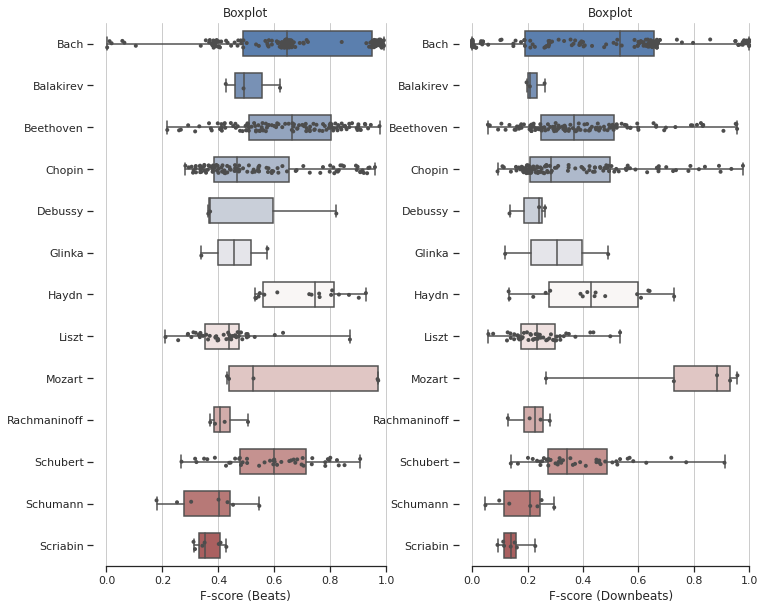

In [27]:
seaborn.set_theme(style="ticks")
plt.subplots(nrows=1,ncols=2,figsize=(12,10))

plt.subplot(1,2,1)

seaborn.boxplot(x="F-score (Beats)", y="Composer", data=my_data[:-1], whis=[0, 100], width=.6, palette="vlag")
seaborn.stripplot(x="F-score (Beats)", y="Composer", data=my_data[:-1], size=4, color=".3", linewidth=0)

plt.gca().xaxis.grid(True)
plt.ylabel("")
plt.title("Boxplot")

plt.subplot(1,2,2)

seaborn.boxplot(x="F-score (Downbeats)", y="Composer", data=my_data[:-1], whis=[0, 100], width=.6, palette="vlag")
seaborn.stripplot(x="F-score (Downbeats)", y="Composer", data=my_data[:-1], size=4, color=".3", linewidth=0)

plt.gca().xaxis.grid(True)
plt.ylabel("")
plt.title("Boxplot")
seaborn.despine(trim=True, left=True)
plt.savefig("Composer_comparison.pdf")
plt.show()

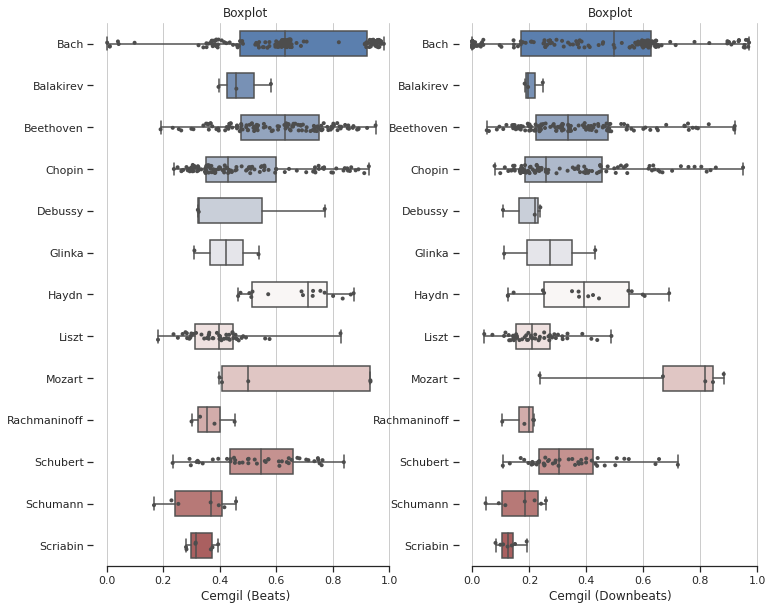

In [29]:
seaborn.set_theme(style="ticks")
plt.subplots(nrows=1,ncols=2,figsize=(12,10))

plt.subplot(1,2,1)

seaborn.boxplot(x="Cemgil (Beats)", y="Composer", data=my_data[:-1], whis=[0, 100], width=.6, palette="vlag")
seaborn.stripplot(x="Cemgil (Beats)", y="Composer", data=my_data[:-1], size=4, color=".3", linewidth=0)

plt.gca().xaxis.grid(True)
plt.ylabel("")
plt.title("Boxplot")

plt.subplot(1,2,2)

seaborn.boxplot(x="Cemgil (Downbeats)", y="Composer", data=my_data[:-1], whis=[0, 100], width=.6, palette="vlag")
seaborn.stripplot(x="Cemgil (Downbeats)", y="Composer", data=my_data[:-1], size=4, color=".3", linewidth=0)

plt.gca().xaxis.grid(True)
plt.ylabel("")
plt.title("Boxplot")
seaborn.despine(trim=True, left=True)
#plt.savefig("C:/Users/Thomas/Desktop/Master_project/Visualizations/Composer_comparison_cemgil.pdf")
plt.show()

## Re-train madmom on the wav-files

#### File lists, Dataset and DataLoader

In [30]:
# Define the training / test split here:
training_split = 0.85

folder_list = list()

for element in audio_files:
    if df.loc[df["audio_performance"] == element]["folder"].iloc[0] not in folder_list:
        folder_list.append(df.loc[df["audio_performance"] == element]["folder"].iloc[0])

random.shuffle(folder_list)
split_index = int(len(folder_list)*training_split)

train_list_folder = folder_list[:split_index]
test_list_folder = folder_list[split_index:]

train_list = list()
test_list = list()

for element in audio_files:
    if df.loc[df["audio_performance"] == element]["folder"].iloc[0] in train_list_folder:
        train_list.append(element)  
    elif df.loc[df["audio_performance"] == element]["folder"].iloc[0] in test_list_folder:
        test_list.append(element)

print(len(train_list),"train files,",len(test_list),"test files.")

416 train files, 103 test files.


In [31]:
class Audio_Dataset_Train(Dataset):
    def __getitem__(self, index):
        
        annotation_file = train_list[index][:-4]+"_annotations.txt"
        beats = beat_list_to_array(annotation_file,"annotations","beats")
        downbeats = beat_list_to_array(annotation_file,"annotations","downbeats")
        
        audio = librosa.load(train_list[index])
        
        s = madmom.audio.Signal(*audio)
        x = preprocessor(s)
        
        return audio, beats, downbeats, index, train_list[index], x
    
    def __len__(self):
        
        return len(train_list)
    
train_list_dataset = Audio_Dataset_Train()

class Audio_Dataset_Test(Dataset):
    def __getitem__(self, index):
        
        annotation_file = test_list[index][:-4]+"_annotations.txt"
        beats = beat_list_to_array(annotation_file,"annotations","beats")
        downbeats = beat_list_to_array(annotation_file,"annotations","downbeats")
        
        audio = librosa.load(test_list[index])

        s = madmom.audio.Signal(*audio)
        x = preprocessor(s)
        
        return audio, beats, downbeats, index, test_list[index], x
    
    def __len__(self):
        
        return len(test_list)
    
test_list_dataset = Audio_Dataset_Test()

test_loader = DataLoader(
    test_list_dataset,
    shuffle=False,
    batch_size=1)

train_loader = DataLoader(
    train_list_dataset,
    shuffle=True,
    batch_size=1)

print(f"Trainingset: {len(train_loader)} samples")
print(f"Testset: {len(test_loader)} samples")

Trainingset: 416 samples
Testset: 103 samples


#### Pre-processing

In [32]:
from madmom.audio.signal import signal_frame, smooth as smooth_signal, SignalProcessor, FramedSignalProcessor
from madmom.ml.nn import average_predictions, NeuralNetwork
from madmom.processors import OnlineProcessor, ParallelProcessor, Processor, SequentialProcessor
from DBNBeatTrackingProcessor import DBNBeatTrackingProcessor
from madmom.audio.stft import ShortTimeFourierTransformProcessor
from madmom.audio.spectrogram import FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor

In [33]:
FPS = 100
FFT_SIZE = 2048
NUM_BANDS = 12

class PreProcessor(SequentialProcessor):
    def __init__(self, frame_size=FFT_SIZE, num_bands=NUM_BANDS, log=np.log, add=1e-6, fps=FPS):
        # resample to a fixed sample rate in order to get always the same number of filter bins
        sig = SignalProcessor(num_channels=1, sample_rate=44100)
        # split audio signal in overlapping frames
        frames = FramedSignalProcessor(frame_size=frame_size, fps=fps)
        # compute STFT
        stft = ShortTimeFourierTransformProcessor()
        # filter the magnitudes
        filt = FilteredSpectrogramProcessor(num_bands=num_bands)
        # scale them logarithmically
        spec = LogarithmicSpectrogramProcessor(log=log, add=add)
        # instantiate a SequentialProcessor
        super(PreProcessor, self).__init__((sig, frames, stft, filt, spec, np.array))
        # safe fps as attribute (needed for quantization of events)
        self.fps = fps
        
preprocessor = PreProcessor()

#### Beat activation function

In [34]:
abc = next(iter(train_loader))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


NoBackendError: ignored

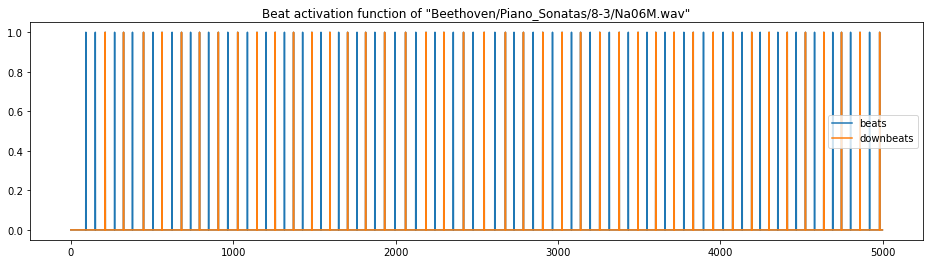

In [ ]:
abcde = madmom.utils.quantize_events(abc[1][0], fps=preprocessor.fps, length=len(abc[5][0]))
abcdef = madmom.utils.quantize_events(abc[2][0], fps=preprocessor.fps, length=len(abc[5][0]))
plt.figure(figsize=(16,4))
plt.plot(np.arange(5000),abcde[:5000],label = "beats")
plt.plot(np.arange(5000),abcdef[:5000],label = "downbeats")
plt.legend()
plt.title("Beat activation function of \""+abc[4][0]+"\"")
plt.show()

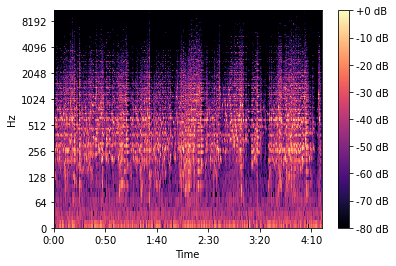

In [ ]:
spec = librosa.amplitude_to_db(np.abs(librosa.stft(np.array(abc[0][0][0]), hop_length=512)), ref=np.max)
img = librosa.display.specshow(spec, y_axis='log', sr=int(abc[0][1]), hop_length=512, x_axis='time')
#plt.vlines(abc[1][0], 0, maketuple[1] / 2, linestyles='dotted', color='w')
#plt.vlines(abc[1][0], 1, 0, sr / 2, color='w')
#plt.title(f'Log-frequency power spectrogram of track: "{song}"')
plt.colorbar(format="%+2.f dB")
plt.show()

#### Network

In [ ]:
class Layer(object):
    """
    Generic callable network layer.
    """

    def __call__(self, *args, **kwargs):
        # this magic method makes a Layer callable
        return self.activate(*args, **kwargs)

    def activate(self, data):
        """
        Activate the layer.
        Parameters
        ----------
        data : numpy array
            Activate with this data.
        Returns
        -------
        numpy array
            Activations for this data.
        """
        raise NotImplementedError('must be implemented by subclass.')

    def reset(self):
        """
        Reset the layer to its initial state.
        """
        return None


class TCNBlock(Layer):
    """
    TCN Block.
    Parameters
    ----------
    dilated_conv : ConvolutionalLayer or List thereof
        Layer(s) which performs the dilated convolution.
    dilation_rate : int, optional or List of ints
        Dilation rate(s) of the `dilated_conv` layer(s).
    activation_fn : numpy ufunc, optional
        Activation function to be applied after the dilated convolution.
    skip_conv : ConvolutionalLayer, optional
        Layer which convolves the output of the dilated convolution to be used
        as skip connection and added to the residual data. If 'None', the
        output after the activation function is used directly.
    residual_conv : ConvolutionalLayer, optional
        Layer which convolves the input data to have the same output dimension
        as the main activation path. If 'None', the input data is added
        directly to the output of the skip convolution.
    """

    def __init__(self, dilated_conv, dilation_rate, activation_fn=None,
                 skip_conv=None, residual_conv=None):
        self.dilated_conv = dilated_conv
        self.dilation_rate = dilation_rate
        self.activation_fn = activation_fn
        self.skip_conv = skip_conv
        self.residual_conv = residual_conv

    @staticmethod
    def _dilate_data(data, size, dilation_rate):
        if dilation_rate is None:
            return data
        # Note: TCNBlock supports only 1D convolutions, data is given as
        #       (time, freq=1, num_features), thus reshape to given size
        #       (time, kernel_size, num_features)
        #       to be able to convolve with normal 2D convolution
        # determine data shape and number of bytes per item
        t, f, n = data.shape
        i = data.itemsize
        assert f == 1, 'TCNBlock supports only 1D dilated convolutions.'
        # to be able to use as_strided we have to pad the data accordingly
        # pad twice the dilation_rate on each side with zeros
        zeros = np.zeros((dilation_rate * 2, f, n), dtype=data.dtype)
        padded_data = np.concatenate((zeros, data, zeros))
        # return a dilated view of the data
        return as_strided(padded_data,
                          shape=(t, size, n),
                          strides=(n * i, n * i * dilation_rate, i))

    def activate(self, data, **kwargs):
        """
        Activate TCNBlock.
        Parameters
        ----------
        data : numpy array
            Activate with this data.
        Returns
        -------
        tuple
            Dilated (and activated) data, skip connection.
        """
        # the layer uses multiple dilated convolutions
        if isinstance(self.dilated_conv, list):
            # layer has multiple dilated convolutions
            out = []
            for conv, rate in zip(self.dilated_conv, self.dilation_rate):
                size = conv.weights.shape[-1]
                out.append(conv(self._dilate_data(data, size, rate)))
            # concatenate their output
            out = np.concatenate(out, axis=-1)
        else:
            # layer has only a single dilated convolutions
            size = self.dilated_conv.weights.shape[-1]
            out = self.dilated_conv(self._dilate_data(data, size,
                                                      self.dilation_rate))
        if self.activation_fn is not None:
            out = self.activation_fn(out)
        if self.skip_conv is not None:
            out = self.skip_conv(out)
        if self.residual_conv is not None:
            res = self.residual_conv(data)
        else:
            res = data
        return res + out, out


class TCNLayer(Layer):
    """
    Temporal convolutional network layer.
    Parameters
    ----------
    tcn_blocks : list of TCNBlock instances
        TCN blocks which perform the dilated convolutions.
    activation_fn : numpy ufunc, optional
        Activation function to be applied after the TCN blocks.
    skip_connections : bool, optional
        Aggregate skip connections by summation.
    """

    def __init__(self, tcn_blocks, activation_fn=None, skip_connections=False):
        self.tcn_blocks = tcn_blocks
        self.skip_connections = skip_connections
        self.activation_fn = activation_fn

    def activate(self, data, **kwargs):
        """
        Activate TCNLayer.
        Parameters
        ----------
        data : numpy array (num_frames, num_inputs)
            Activate with this data.
        Returns
        -------
        numpy array or tuple
            Activations for this data. If `skip_connections` is 'True', a tuple
            with the summed skip connections as its second element is returned.
        """
        skip_connections = None
        for i, tcn_block in enumerate(self.tcn_blocks):
            data, skip = tcn_block(data)
            if i == 0:
                skip_connections = skip
            else:
                skip_connections += skip
        if self.activation_fn is not None:
            self.activation_fn(data, out=data)
        if self.skip_connections:
            return data, skip_connections
        else:
            return data

In [ ]:
class my_madmom(nn.Module):

    def __init__(self):
        super(my_madmom,self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20,kernel_size=(1,3),padding="valid")
        self.act1 = torch.nn.ELU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(1,3))
        self.dropout1 = torch.nn.Dropout(0.15)
        
        self.conv2 = torch.nn.Conv2d(in_channels=20, out_channels=20,kernel_size=(1,10),padding="valid")
        self.act2 = torch.nn.ELU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=(1,3))
        self.dropout2 = torch.nn.Dropout(0.15)
        
        self.conv3 = torch.nn.Conv2d(in_channels=20, out_channels=20,kernel_size=(1,3),padding="valid")
        self.act3 = torch.nn.ELU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=(1,3))
        self.dropout3 = torch.nn.Dropout(0.15)
        
        self.res_x = torch.nn.Conv1d(in_channels=20,out_channels=20, kernel_size=1, padding='same')
        
        self.activation4 = torch.nn.ELU()
        self.dropout4 = torch.nn.Dropout(0.15)
        
        self.conv1d = torch.nn.Conv1d(in_channels=40, out_channels=20,kernel_size=1, padding='same')
        
        self.activation5 = torch.nn.ELU()
        
        self.beats1 = torch.nn.Dropout(0.15)
        self.beats2 = torch.nn.Linear(in_features=20,out_features=1)
        self.beats3 = torch.nn.Sigmoid()
        
        self.downbeats1 = torch.nn.Dropout(0.15)
        self.downbeats2 = torch.nn.Linear(in_features=20,out_features=1)
        self.downbeats3 = torch.nn.Sigmoid() 
        
        self.name = 'tcn'
        self.dropout_rate = 0.15
        self.activation = 'elu'
        self.dilations = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
        self.kernel_size = 5
        self.num_filters = [20] * len(self.dilations)
        self.padding = 'same'
        
        self.layer_list = torch.nn.ModuleList()
        self.layer_list_2 = torch.nn.ModuleList()
        
        for i in self.dilations:
            self.layer_list.append(torch.nn.Conv1d(in_channels=20, out_channels=20, kernel_size=self.kernel_size, dilation=i, padding=self.padding))
            self.layer_list_2.append(torch.nn.Conv1d(in_channels=20, out_channels=20, kernel_size=self.kernel_size, dilation=i*2, padding=self.padding))
        
    def forward(self,x):
        #print("Input shape:",x.shape)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        #print("Shape after conv1:",x.shape)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        #print("Shape after conv2:",x.shape)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        #print("Shape after conv3:",x.shape)
        x = torch.reshape(x,(20,-1))
              
        #print("Shape after reshape:",x.shape)
        
        #TCN Block:
        
        #dilations = [2 ** i for i in range(num_dilations)]
        #tcn, skip = TCNLayer(
            #num_filters=[self.num_filters] * len(self.dilations),
            #kernel_size=self.kernel_size,
            #dilations=self.dilations,
            #activation=self.activation,
            #padding='same',
            #dropout_rate=self.dropout_rate,
        #)(x)
        
        # TCN:
        skip_connections = []
        # build the TCN models
        indx = 0
        for i, num_filters in zip(self.dilations, self.num_filters):
            # feed the output of the previous layer into the next layer
            # increase dilation rate for each consecutive layer
            # Residual block:
            
            name = self.name + '_dilation_%d' % i
            # 1x1 conv. of input (so it can be added as residual)
            res_x = self.res_x(x)
                        
            conv_1 = self.layer_list[indx](x)
            conv_2 = self.layer_list_2[indx](x)
                        
            indx += 1
    
            # concatenate the output of the two dilations
            concat = torch.cat((conv_1,conv_2))
            
            # apply activation function
            x_res = self.activation4(concat)
            
            # apply spatial dropout
            x_res = torch.transpose(x_res,0,1)
            x_res = self.dropout4(x_res)
            x_res = torch.transpose(x_res,0,1)
            
            # 1x1 conv. to obtain a representation with the same size as the residual
            x_res = self.conv1d(x_res)
            
            # add the residual to the processed data and also return it as skip connection
            x = torch.add(res_x,x_res)
            
            # collect skip connection
            skip_connections.append(x_res)
        # activate the output of the TCN stack
        x = self.activation5(x)
        
        beats = self.beats1(x)
        beats = torch.transpose(beats,0,1)
        beats = self.beats2(beats)
        beats = self.beats3(beats)   
        
        downbeats = self.downbeats1(x)
        downbeats = torch.transpose(downbeats,0,1)
        downbeats = self.downbeats2(downbeats)
        downbeats = self.downbeats3(downbeats) 
        
        #x = self.output(x)
        
        return beats

#### Training loop

Training Started! Device: cpu 
Trainable parameters: 51042

EPOCH 1 of 2

Sample 1 / 442 --- Rachmaninoff/Preludes_op_32/5/Namirovsky06M.wav --- Input shape: torch.Size([1, 16411, 81])
Loss: 0.7489 --- F-Score: 0.2038 --- Time: 00:00:09 

Sample 2 / 442 --- Liszt/Transcendental_Etudes/4/GuoE03M.wav --- Input shape: torch.Size([1, 48606, 81])
Loss: 0.5997 --- F-Score: 0.2778 --- Time: 00:00:42 

Sample 3 / 442 --- Beethoven/Piano_Sonatas/26-1/Zhdanov05M.wav --- Input shape: torch.Size([1, 39453, 81])
Loss: 0.4204 --- F-Score: 0.4312 --- Time: 00:01:08 

Sample 4 / 442 --- Beethoven/Piano_Sonatas/27-1/GiacomelliN04M.wav --- Input shape: torch.Size([1, 31946, 81])
Loss: 0.1801 --- F-Score: 0.3823 --- Time: 00:01:29 

Sample 5 / 442 --- Bach/Fugue/bwv_874/WongWY01M.wav --- Input shape: torch.Size([1, 19993, 81])
Loss: 0.0361 --- F-Score: 0.1387 --- Time: 00:01:43 

Sample 6 / 442 --- Bach/Fugue/bwv_892/KabuliL01M.wav --- Input shape: torch.Size([1, 23224, 81])
Loss: 0.1330 --- F-Score: 0.2

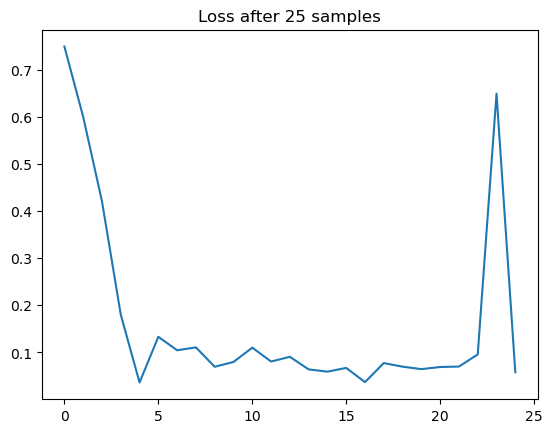

Average F-Score: 0.2634333759038023 

Sample 26 / 442 --- Debussy/Pour_le_Piano/1/MunA12M.wav --- Input shape: torch.Size([1, 22550, 81])
Loss: 0.1085 --- F-Score: 0.3629 --- Time: 00:07:31 

Sample 27 / 442 --- Bach/Prelude/bwv_889/Giesbrecht01M.wav --- Input shape: torch.Size([1, 14484, 81])
Loss: 0.0659 --- F-Score: 0.2021 --- Time: 00:07:40 

Sample 28 / 442 --- Bach/Fugue/bwv_874/BianF01.wav --- Input shape: torch.Size([1, 17291, 81])
Loss: 0.0992 --- F-Score: 0.1135 --- Time: 00:07:51 

Sample 29 / 442 --- Bach/Prelude/bwv_854/WangA01M.wav --- Input shape: torch.Size([1, 8463, 81])
Loss: 0.0817 --- F-Score: 0.2274 --- Time: 00:07:56 

Sample 30 / 442 --- Haydn/Keyboard_Sonatas/50-1_no_repeat/KARYAG06M.wav --- Input shape: torch.Size([1, 30365, 81])
Loss: 0.1005 --- F-Score: 0.3240 --- Time: 00:08:14 

Sample 31 / 442 --- Bach/Prelude/bwv_848/MiyashitaM01M.wav --- Input shape: torch.Size([1, 7557, 81])
Loss: 0.1822 --- F-Score: 0.5282 --- Time: 00:08:21 

Sample 32 / 442 --- Beeth

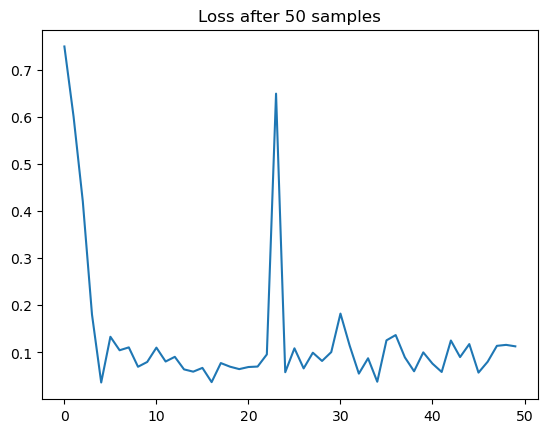

Average F-Score: 0.2893974229083042 



KeyboardInterrupt: 

In [ ]:
num_epochs = 2

#model = torch.load("models/checkpoints/model_iter_100.pt")
model = my_madmom()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

#writer = SummaryWriter()

#if torch.cuda.is_available():
    #model.cuda()
    
device = next(model.parameters()).device
          
iter=0
iter_new=0 

criterion = torch.nn.BCELoss()

learning_rate = 0.005
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
                                                                              
begin_time = time.time()
print("Training Started! Device:",device,"\nTrainable parameters:",params)
for epoch in range(num_epochs):
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    loss_list = list()
    fscore_list = list()
    for i,datapoint in enumerate(train_loader):

        #if torch.cuda.is_available():
            #datapoint[5] = datapoint[5].cuda()
        optimizer.zero_grad()
        sample_number = (iter%len(train_loader))+1
        print("Sample",sample_number,"/",len(train_loader),"---",datapoint[4][0],"--- Input shape:",datapoint[5].shape)
        
        outputs = model(datapoint[5])
        
        #print("Output shape:",outputs[:,0].shape)
                        
        beat_activation = madmom.utils.quantize_events(datapoint[1][0], fps=preprocessor.fps, length=len(datapoint[5][0]))
        #beat_activation = torch.tensor(beat_activation[:-4])
        beat_activation = torch.tensor(beat_activation)
        
        loss = criterion(outputs[:,0].float(),beat_activation.float())
        
        #Calculate F-Score:
        proc = madmom.features.beats.DBNBeatTrackingProcessor(fps=100)
        try:
            beat_times = proc(outputs[:,0].detach().numpy())
            evaluate = mir_eval_beat.evaluate(np.array(datapoint[1][0]),beat_times)
            fscore = evaluate["F-measure"]
            fscore_list.append(fscore)
        except:
            print("Sample can not be processed.")
        
        timestamp = time.time()-begin_time
        
        #print("Loss:",loss.item(),"--- F-Score:",fscore,"--- Time:",str(datetime.timedelta(seconds=timestamp)),"s\n")
        print("Loss:","%.4f"%loss.item(),"--- F-Score:","%.4f"%fscore,"--- Time:",str(time.strftime("%H:%M:%S", time.gmtime(timestamp))),"\n")
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()        
        
        #writer.add_scalar('Training Loss',loss.data.item()/10, iter)
        iter=iter+1
        
        if iter % 25 == 0:
            plt.plot(np.arange(len(loss_list)),loss_list)
            plt.title("Loss after "+str(sample_number)+" samples")
            plt.show()
            print("Average F-Score:",np.sum(fscore_list)/len(fscore_list),"\n")
        
        if iter % 100 == 0:
                    
            val_loss = 0
            total = 0
            
            fscore_list_test = list()
            
            test_loader_indices = np.random.permutation(range(len(test_loader)))[:25]
            
            for j, datapoint_test in enumerate(test_loader):
                
                if j > 25:
                    break
                
                print("Test sample number",j+1,"/",len(test_loader),"--- File path:",datapoint_test[4][0])
                outputs = model(datapoint_test[5])

                beat_activation = madmom.utils.quantize_events(datapoint_test[1][0], fps=preprocessor.fps, length=len(datapoint_test[5][0]))
                #beat_activation = torch.tensor(beat_activation[:-4])
                beat_activation = torch.tensor(beat_activation)

                loss_test = criterion(outputs[:,0].float(),beat_activation.float())
                print("test Loss:","%.4f"%loss_test.item())

                #Calculate F-Score:
                proc = madmom.features.beats.DBNBeatTrackingProcessor(fps=100)
                beat_times = proc(outputs[:,0].detach().numpy())
                evaluate = mir_eval_beat.evaluate(np.array(datapoint[1][0]),beat_times)
                f_score_test = evaluate["F-measure"]
                fscore_list_test.append(f_score_test)
                print("F-Score:",f_score_test,"--- Average validation F-Score:",np.sum(fscore_list_test)/len(fscore_list_test),"\n")
                
                val_loss += loss_test
                #total += datapoint_test[0].size(0)
            
            print("Validation summary:")
            #val_loss = val_loss/total
            #writer.add_scalar('Validation Loss',val_loss, iter) 
            
            time_since_begin = (time.time() - begin_time)/60
            print('Iteration: {}. Loss: {}. Validation Loss: {}. Time(mins) {}\n'.format(iter, loss.data.item()/10, val_loss,time_since_begin))
        if iter % 100 == 0:
            torch.save(model,'models/checkpoints/model_iter_'+str(iter)+'.pt')
            print("Model saved at iteration: "+str(iter)+"\n")
            #writer.export_scalars_to_json("../graphs/all_scalars_"+str(iter_new)+".json")
    scheduler.step()
#writer.close()

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])
tensor([ 0.2355,  0.6745, -1.9644,  0.8330,  0.0441,  0.7794, -0.0482, -1.0579,
         0.5270,  0.6277], requires_grad=True)
tensor([0.5586, 0.6625, 0.1230, 0.6970, 0.5110, 0.6855, 0.4880, 0.2577, 0.6288,
        0.6520], grad_fn=<SigmoidBackward0>)


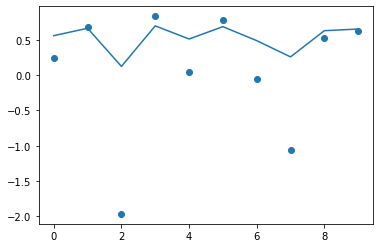

In [ ]:
tensor01 = torch.randint(2,(10,)).float()
tensor02 = torch.randn(10,requires_grad=True)
act = torch.nn.Sigmoid()
print(tensor01)
print(tensor02)
print(act(tensor02))
torch.nn.BCELoss()(act(tensor02),tensor01)
plt.scatter(np.arange(10),tensor02.detach().numpy())
plt.plot(act(tensor02).detach().numpy())
plt.show()

## Piano rolls playground (not needed for Project)

In [ ]:
fn = 'Bach/Fugue/bwv_846/Shi05M.mid'
#pt.load_score_midi(fn, part_voice_assign_mode=0, ensure_list=False, quantization_unit=None, estimate_voice_info=True, estimate_key=False, assign_note_ids=True)[source]

In [ ]:
# Use midi_performance
# unisntall partitura
# ! pip install git+https://github.com/CPJKU/partitura.git@develop
#path_to_midifile = pt.EXAMPLE_MIDI
#performedpart = pt.load_performance_midi(path_to_midifile)


folder = 'Bach/Fugue/bwv_846'
score_fn = os.path.join(folder,'xml_score.musicxml')
# Load the score
score_part = pt.load_musicxml(score_fn)
# compute piano roll
pianoroll = pt.utils.compute_pianoroll(score_part)

In [ ]:
pianoroll

<128x860 sparse matrix of type '<class 'numpy.intc'>'
	with 2753 stored elements in Compressed Sparse Column format>

### Save piano rolls and test plot

In [ ]:
piano_range = True
time_unit = 'beat'
time_div = 10

In [ ]:
for i,element in enumerate(xml_files[:12]):
    print(i)
    score_part = pt.load_musicxml(element)
    pianoroll = pt.utils.compute_pianoroll(
        note_info=score_part, # a `Part`, `PerformedPart` or a note array
        time_unit=time_unit, # beat, quarter, div, sec, etc. (depending on note_info)
        time_div=time_div, # Number of cells per time unit
        piano_range=piano_range # Use range of the piano (88 keys)
    )
    folder = xml_files[:12][i][:-9]+"_pianoroll.pkl"
    with open(folder, 'wb') as f:
        pickle.dump(pianoroll,f)

0
1
2
3
4
5
6
7
8
9
10
11


In [ ]:
test_open = 'Bach/Fugue/bwv_846/xml_score_pianoroll.pkl'
with open(test_open, 'rb') as f:
    pianoroll_test = pickle.load(f)

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.imshow(pianoroll_test.toarray(), origin="lower", cmap='gray', interpolation='nearest', aspect='auto')
ax.set_xlabel(f'Time ({time_unit}s/{time_div})')
ax.set_ylabel('Piano key' if piano_range else 'MIDI pitch')
plt.show()

In [ ]:
pianoroll, note_indices = pt.utils.compute_pianoroll(score_part, return_idxs=True)
#print(note_indices)
new_note_array = pt.utils.pianoroll_to_notearray(pianoroll)
print(new_note_array.dtype.names)
print(new_note_array)

('pitch', 'onset_sec', 'duration_sec', 'velocity', 'id')
[(60,   0.   ,  0.5  , 1, 'n0') (62,   0.5  ,  0.5  , 1, 'n1')
 (64,   1.   ,  0.5  , 1, 'n2') (65,   1.5  ,  0.75 , 1, 'n3')
 (67,   2.25 ,  0.125, 1, 'n4') (65,   2.375,  0.125, 1, 'n5')
 (64,   2.5  ,  0.5  , 1, 'n6') (69,   3.   ,  0.5  , 1, 'n7')
 (62,   3.5  ,  0.5  , 1, 'n8') (67,   4.   ,  0.75 , 1, 'n9')
 (69,   4.75 ,  0.25 , 1, 'n10') (67,   5.   ,  0.25 , 1, 'n11')
 (65,   5.25 ,  0.25 , 1, 'n12') (64,   5.5  ,  0.25 , 1, 'n13')
 (65,   5.75 ,  0.25 , 1, 'n14') (64,   6.   ,  0.25 , 1, 'n15')
 (67,   6.   ,  0.5  , 1, 'n16') (62,   6.25 ,  0.25 , 1, 'n17')
 (60,   6.5  ,  0.25 , 1, 'n18') (69,   6.5  ,  0.5  , 1, 'n19')
 (62,   6.75 ,  0.25 , 1, 'n20') (60,   7.   ,  0.5  , 1, 'n21')
 (71,   7.   ,  0.25 , 1, 'n22') (59,   7.25 ,  0.25 , 1, 'n23')
 (57,   7.5  ,  0.5  , 1, 'n24') (72,   7.5  ,  0.75 , 1, 'n25')
 (66,   8.   ,  0.5  , 1, 'n26') (74,   8.25 ,  0.125, 1, 'n27')
 (72,   8.375,  0.125, 1, 'n28') (67,   8.5

### Model playground

In [ ]:
from madmom.audio.signal import signal_frame, smooth as smooth_signal
from madmom.ml.nn import average_predictions, NeuralNetwork
from madmom.processors import (OnlineProcessor, ParallelProcessor, Processor, SequentialProcessor)
from DBNBeatTrackingProcessor import DBNBeatTrackingProcessor

In [ ]:
class RNNBeatProcessor(SequentialProcessor):
    """
    Processor to get a beat activation function from multiple RNNs.

    Parameters
    ----------
    post_processor : Processor, optional
        Post-processor, default is to average the predictions.
    online : bool, optional
        Use signal processing parameters and RNN models suitable for online
        mode.
    nn_files : list, optional
        List with trained RNN model files. Per default ('None'), an ensemble
        of networks will be used.

    References
    ----------
    .. [1] Sebastian Böck and Markus Schedl,
           "Enhanced Beat Tracking with Context-Aware Neural Networks",
           Proceedings of the 14th International Conference on Digital Audio
           Effects (DAFx), 2011.

    Examples
    --------
    Create a RNNBeatProcessor and pass a file through the processor.
    The returned 1d array represents the probability of a beat at each frame,
    sampled at 100 frames per second.

    >>> proc = RNNBeatProcessor()
    >>> proc  # doctest: +ELLIPSIS
    <madmom.features.beats.RNNBeatProcessor object at 0x...>
    >>> proc('tests/data/audio/sample.wav')  # doctest: +ELLIPSIS
    array([0.00479, 0.00603, 0.00927, 0.01419, ... 0.02725], dtype=float32)

    For online processing, `online` must be set to 'True'. If processing power
    is limited, fewer number of RNN models can be defined via `nn_files`. The
    audio signal is then processed frame by frame.

    >>> from madmom.models import BEATS_LSTM
    >>> proc = RNNBeatProcessor(online=True, nn_files=[BEATS_LSTM[0]])
    >>> proc  # doctest: +ELLIPSIS
    <madmom.features.beats.RNNBeatProcessor object at 0x...>
    >>> proc('tests/data/audio/sample.wav')  # doctest: +ELLIPSIS
    array([0.03887, 0.02619, 0.00747, 0.00218, ... 0.04825], dtype=float32)

    """

    def __init__(self, post_processor=average_predictions, online=False,
                 nn_files=None, **kwargs):
        # pylint: disable=unused-argument
        from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
        from madmom.audio.stft import ShortTimeFourierTransformProcessor
        from madmom.audio.spectrogram import (FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor, SpectrogramDifferenceProcessor)
        from madmom.ml.nn import NeuralNetworkEnsemble
        from madmom.models import BEATS_LSTM, BEATS_BLSTM
        # choose the appropriate models and set frame sizes accordingly
        if online:
            if nn_files is None:
                nn_files = BEATS_LSTM
            frame_sizes = [2048]
            num_bands = 12
        else:
            if nn_files is None:
                nn_files = BEATS_BLSTM
            frame_sizes = [1024, 2048, 4096]
            num_bands = 6
                    
        # define pre-processing chain
        sig = SignalProcessor(num_channels=1, sample_rate=44100)
        
        # process the multi-resolution spec & diff in parallel
        multi = ParallelProcessor([])
        for frame_size in frame_sizes:
            frames = FramedSignalProcessor(frame_size=frame_size, **kwargs)
            stft = ShortTimeFourierTransformProcessor()  # caching FFT window
            filt = FilteredSpectrogramProcessor(num_bands=num_bands, fmin=30,
                                                fmax=17000, norm_filters=True)
            spec = LogarithmicSpectrogramProcessor(mul=1, add=1)
            diff = SpectrogramDifferenceProcessor(
                diff_ratio=0.5, positive_diffs=True, stack_diffs=np.hstack)
            # process each frame size with spec and diff sequentially
            multi.append(SequentialProcessor((frames, stft, filt, spec, diff)))
        # stack the features and processes everything sequentially
        pre_processor = SequentialProcessor((sig, multi, np.hstack))
        # process the pre-processed signal with a NN ensemble and the given
        # post_processor
        nn = NeuralNetworkEnsemble.load(nn_files,
                                        ensemble_fn=post_processor, **kwargs)
        # instantiate a SequentialProcessor
        super(RNNBeatProcessor, self).__init__((pre_processor, nn))

#### Network tests

In [ ]:
from madmom.models import BEATS_LSTM, BEATS_BLSTM
with open(BEATS_BLSTM[3], 'rb') as f:
    lstm = pickle.load(f, encoding='latin1')
help(lstm)

Help on NeuralNetwork in module madmom.ml.nn object:

class NeuralNetwork(madmom.processors.Processor)
 |  NeuralNetwork(layers)
 |  
 |  Neural Network class.
 |  
 |  Parameters
 |  ----------
 |  layers : list
 |      Layers of the Neural Network.
 |  
 |  Examples
 |  --------
 |  Create a NeuralNetwork from the given layers.
 |  
 |  >>> from madmom.ml.nn.layers import FeedForwardLayer
 |  >>> from madmom.ml.nn.activations import tanh, sigmoid
 |  >>> l1_weights = np.array([[0.5, -1., -0.3 , -0.2]])
 |  >>> l1_bias = np.array([0.05, 0., 0.8, -0.5])
 |  >>> l1 = FeedForwardLayer(l1_weights, l1_bias, activation_fn=tanh)
 |  >>> l2_weights = np.array([-1, 0.9, -0.2 , 0.4])
 |  >>> l2_bias = np.array([0.5])
 |  >>> l2 = FeedForwardLayer(l2_weights, l2_bias, activation_fn=sigmoid)
 |  >>> nn = NeuralNetwork([l1, l2])
 |  >>> nn  # doctest: +ELLIPSIS
 |  <madmom.ml.nn.NeuralNetwork object at 0x...>
 |  >>> nn(np.array([[0], [0.5], [1], [0], [1], [2], [0]]))
 |  ... # doctest: +NORMALIZE

In [ ]:
from madmom.ml.nn.layers import FeedForwardLayer, BidirectionalLayer
from madmom.ml.nn.activations import tanh, sigmoid
l1_weights = np.array([[0.5, -1., -0.3 , -0.2]])
l1_bias = np.array([0.05, 0., 0.8, -0.5])
l1 = FeedForwardLayer(l1_weights, l1_bias, activation_fn=tanh)
l2_weights = np.array([-1, 0.9, -0.2 , 0.4])
l2_bias = np.array([0.5])
l2 = FeedForwardLayer(l2_weights, l2_bias, activation_fn=sigmoid)
nn = NeuralNetwork([l1, l2])

In [ ]:
input_1 = np.array([[1,2,3,4]]).T
print(nn(input_1))

[0.26500296 0.18611938 0.16664405 0.16307956]


In [ ]:
lstm.layers[0].fwd_layer.input_gate.weights

array([[ 2.23015e-01,  1.16018e-01,  4.03215e-02,  2.03331e-02,
        -1.15187e-01, -1.28011e-01,  2.25913e-01, -2.14153e-01,
         9.72799e-02, -1.31685e-02,  1.82248e-01, -3.63736e-02,
         3.15328e-02,  1.25977e-01, -1.24357e-01, -1.50442e-01,
        -1.74845e-02, -3.17956e-02, -2.00486e-01, -3.16272e-01,
        -5.24055e-02,  2.19210e-01, -4.39121e-02,  5.09922e-02,
        -2.03646e-02],
       [-5.20427e-02, -2.52208e-02, -2.64626e-02, -2.74164e-02,
        -1.11077e-01, -3.04335e-01, -8.43268e-02,  4.03954e-02,
        -8.45648e-02, -1.80633e-01, -9.37531e-02,  1.09412e-01,
         1.94999e-02,  1.22273e-02,  5.91785e-02, -1.21620e-01,
         1.66039e-01, -1.33072e-01, -9.71109e-02, -2.74393e-01,
         2.57058e-02,  3.47937e-02,  9.58596e-02,  7.08870e-02,
         5.03603e-03],
       [-2.91056e-02,  5.29549e-02, -5.61609e-02,  3.16753e-01,
        -2.51504e-01, -2.23550e-01, -1.69165e-01, -7.82941e-02,
         9.00196e-02, -1.50317e-01, -7.78402e-02, -2.10709

In [ ]:
l1 = lstm.layers[0]
l2 = lstm.layers[1]
l3 = lstm.layers[2]
l4_weights = lstm.layers[3].weights
l4_bias = np.array([-2.7259])
l4 = FeedForwardLayer(l4_weights,l4_bias,activation_fn=sigmoid)
nn = NeuralNetwork([l1, l2, l3, l4])
input_2 = np.random.random((2,266))
print(nn(input_2))
with open("nn_test.pkl", 'wb') as f:
    pickle.dump(nn, f)

[0.48452828 0.33592431]


#### SIgnal processor

In [ ]:
from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
frames = FramedSignalProcessor(frame_size=1024)
file = frames(wav_files[0])
file

## Reconstruction in torch

#### Pianoroll Dataset and Dataloader

In [ ]:
pianoroll_files = list()
for (dirpath, dirnames, filenames) in os.walk("."):
    pianoroll_files += [os.path.join(dirpath, file) for file in filenames if file[-13:] == "pianoroll.pkl"]
pianoroll_files = sorted(pianoroll_files)


midi_annotations = list()
#for (dirpath, dirnames, filenames) in os.walk("."):
#    midi_annotations += [os.path.join(dirpath, file) for file in filenames if file[-26:] == "midi_score_annotations.txt"]
#midi_annotations = sorted(midi_annotations)

for i in range(len(pianoroll_files)):
    midi_annotation = pianoroll_files[i][:-23]+"midi_score_annotations.txt"
    midi_annotations.append(midi_annotation)


class Pianoroll_Dataset(Dataset):
    def __getitem__(self, index):
        
        with open(pianoroll_files[index], 'rb') as f:
            pianoroll_test = pickle.load(f)
            
        pianoroll_tensor = torch.tensor(pianoroll_test.toarray().T)
        
        label_array = beat_list_to_array(midi_annotations[index],"annotations")
        label_tensor = torch.tensor(label_array)
        
        return pianoroll_tensor, label_tensor, index, pianoroll_files[index]
    
    def __len__(self):
        
        return len(pianoroll_files)
    
pianoroll_dataset = Pianoroll_Dataset()

n_samples = len(pianoroll_dataset)

print("Number of piano rolls:",n_samples)

rng = np.random.default_rng(seed=0)
shuffled_indices = rng.permutation(n_samples)
testset_idx = shuffled_indices[:int(n_samples / 5)]
validationset_idx = shuffled_indices[int(n_samples / 5):int(n_samples / 5) * 2]
trainingset_idx = shuffled_indices[int(n_samples / 5) * 2:]

testset = Subset(pianoroll_dataset, indices=testset_idx)
validationset = Subset(pianoroll_dataset, indices=validationset_idx)
trainingset = Subset(pianoroll_dataset, indices=trainingset_idx)

test_loader = DataLoader(
    testset,
    shuffle=False,
    batch_size=1)

validation_loader = DataLoader(
    validationset,
    shuffle=False,
    batch_size=1)

train_loader = DataLoader(
    trainingset,
    shuffle=True,
    batch_size=1)

print(f"trainingset ({len(trainingset)} samples)")
print(f"validationset ({len(validationset)} samples)")
print(f"testset ({len(testset)} samples)")

Number of piano rolls: 234
trainingset (142 samples)
validationset (46 samples)
testset (46 samples)


('.\\Beethoven\\Piano_Sonatas\\26-2\\xml_score_pianoroll.pkl',)


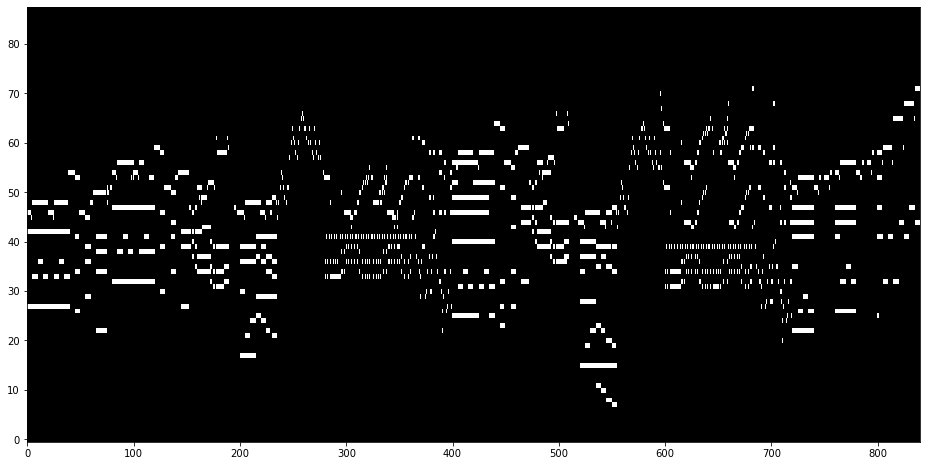

In [ ]:
abcd = next(iter(train_loader))
a = abcd[0].numpy().squeeze()
print(abcd[3])
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.imshow(a.T, origin="lower", cmap='gray', interpolation='nearest', aspect='auto')
plt.show()

#### Network

In [ ]:
class my_lstm(nn.Module):

    def __init__(self):
        super(my_lstm,self).__init__()
        
        self.layer1 = torch.nn.LSTM(input_size=88, hidden_size=25, num_layers = 3, bidirectional = True)
        self.linear = torch.nn.Linear(in_features=50,out_features=3)
        self.output = torch.nn.Softmax(dim=1)
        
    def forward(self,x):
        
        x = self.layer1(x)
        x = self.linear(x[0])
        x = self.output(x)
        
        return x

#### Training loop

In [ ]:
num_epochs = 1

model = my_lstm()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

#writer = SummaryWriter()

#if torch.cuda.is_available():
#    model.cuda()
    
device = next(model.parameters()).device
          
iter=0
iter_new=0 

criterion = nn.CrossEntropyLoss()

learning_rate = 0.00001
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
                                                                              
begin_time = time.time()
print("Training Started! Device:",device,"\nTrainable parameters:",params)
for epoch in range(num_epochs):
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    for i,datapoint in enumerate(train_loader):

        pianoroll = datapoint[0].type(torch.FloatTensor)
        label = datapoint[1].type(torch.FloatTensor)
                
        #if torch.cuda.is_available():
            #pianoroll = pianoroll.cuda()
            #label = label.cuda()

        optimizer.zero_grad()
        outputs = model(pianoroll)
        
        loss = criterion(outputs,label)
        loss.backward()
        optimizer.step()
        #writer.add_scalar('Training Loss',loss.data.item()/10, iter)
        iter=iter+1
        
        if iter % 50 == 0:
                    
            val_loss = 0
            total = 0
            
            for j, datapoint_1 in enumerate(validation_loader):
                pianoroll_val = datapoint_1[0].type(torch.FloatTensor)
                label_val = datapoint_1[1].type(torch.FloatTensor)
           
                if torch.cuda.is_available():
                    pianoroll_val = pianoroll_val.cuda()
                    label_val = label_val.cuda()
                
                outputs = model(pianoroll_val)
                val_loss += torch.tensor([0.5],requires_grad=True)
                total += datapoint_1[2].size(0)
            val_loss = val_loss/total
            #writer.add_scalar('Validation Loss',val_loss, iter) 
            
            time_since_begin = (time.time() - begin_time)/60
            print('Iteration: {}. Loss: {}. Validation Loss: {}. Time(mins) {}'.format(iter, loss.data.item()/10, val_loss,time_since_begin))
        #if iter % 2000 == 0:
            #torch.save(model,'../checkpoints/model_iter_'+str(iter)+'.pt')
            #print("model saved at iteration : "+str(iter))
            #writer.export_scalars_to_json("../graphs/all_scalars_"+str(iter_new)+".json")
    scheduler.step()            
#writer.close()

Training Started! Device: cpu 
Trainable parameters: 53953

EPOCH 1 of 1



RuntimeError: Expected target size [1, 3], got [1, 282]

### Piano roll predictions

In [ ]:
proc = DBNBeatTrackingProcessor(fps=100)
act = RNNBeatProcessor(nn_files=["nn_test.pkl"])(wav_files[0])
print(act[0:40])
print(len(act))
beat_times = proc(act)

[3.72028565e-02 1.00986292e-02 3.48041025e-03 1.67108066e-03
 9.65571599e-04 5.97920454e-04 3.91323639e-04 2.80802462e-04
 2.27904229e-04 2.08020334e-04 2.05007816e-04 2.10276625e-04
 2.21684379e-04 2.41655721e-04 2.73563358e-04 3.05321476e-04
 3.07389350e-04 2.67822644e-04 2.09841804e-04 1.62395955e-04
 1.38943652e-04 1.33073296e-04 1.34504214e-04 1.41099766e-04
 1.51305107e-04 1.48806366e-04 1.21335035e-04 8.51288836e-05
 6.06663096e-05 4.92028779e-05 4.39554156e-05 4.12441919e-05
 4.15255443e-05 4.77966990e-05 6.15502500e-05 7.58671445e-05
 7.76098382e-05 6.82554290e-05 6.09349327e-05 6.45247735e-05]
14760


In [ ]:
proc2 = DBNBeatTrackingProcessor(fps=100)
act2 = RNNBeatProcessor(nn_files=["nn_test.pkl"])(wav_files[1])
print(act2[0:40])
beat_times2 = proc2(act2)

[0.00608107 0.00556719 0.00530875 0.0045536  0.00367491 0.00309355
 0.00289948 0.00302649 0.00340461 0.00396998 0.00463475 0.00530668
 0.00593955 0.00652615 0.00703317 0.00734241 0.00735564 0.00708119
 0.00657154 0.00594936 0.00541768 0.0050265  0.004662   0.00424139
 0.00377836 0.00333524 0.00296837 0.00270685 0.00255801 0.00251955
 0.00258563 0.00274122 0.00294405 0.00311175 0.00315189 0.00303387
 0.00283489 0.00270202 0.00275899 0.00306525]


In [ ]:
criterion(torch.tensor(act),torch.tensor(act2))

RuntimeError: size mismatch (got input: [14760], target: [11221])